# Twitter hate speech detection 
## Data Cleaning and Prep

### December 8, 2021
### Clare Garberg (cag199) & Abby Fremaux (amf338)

### Objectives:
1. Examine raw data
2. Subset data into a working size
3. Clean data with manual methods and a spaCy text-preprocessing pipeline
4. Build a bag-of-words document term matrix

In [1]:
## importing necessary libraries
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.language import Language
import seaborn as sns

In [2]:
## Setting working directory

os.chdir("/Users/claregarberg/Documents/Graduate School/Fall 2021 Semester/580 NLP for Data Analytics/")

### importing data

tweets_data = pd.read_csv('train.csv', lineterminator='\n')

## looking at number of hate tweets vs not
for i in range(2):
    if  i == 0:
        print(f"Non-Hate Tweets: {sum(tweets_data['label'] == i) / len(tweets_data):.3f}")
    else:
        print(f"Hate Tweets: {sum(tweets_data['label'] == i) / len(tweets_data):.3f}")

## looking at tweets before preprocessing
tweets_data["tweet"]

Non-Hate Tweets: 0.930
Hate Tweets: 0.070


0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

In [3]:
## trying to get a more balanced subset
hate_tweets = tweets_data[tweets_data['label'] == 1]
hate_tweets_sample = hate_tweets.sample(1000, random_state=43)

non_hate_tweets = tweets_data[tweets_data['label'] == 0]
non_hate_tweets_sample = non_hate_tweets.sample(1000, random_state=43)

# we do not have the processing power for a this much data so we will take a sample
tweets_data = pd.concat([non_hate_tweets_sample, hate_tweets_sample])

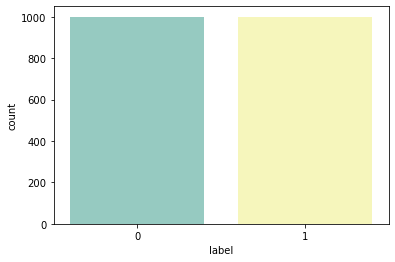

In [4]:
## visualizing label frequencies

plot = sns.countplot(x="label", data=tweets_data, palette="Set3")

In [5]:
## defining data cleaning pipeline

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " "),                   # Stips extra whitespace
    (r"[\n\t\r]", " "),             # Removes newlines, tabs, creturn
    (r"[^\x00-\x7F]+", ""),        # Removes non-ascii chars
    (r"\\+", " "),                    # Removes double-backslashs
    (r"\s+n\s+", " ")                  # 'n' leftover from \\n
]

tweets_list = []
for i, d in enumerate(tweets_data['tweet']):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    tweets_list.append(d)


@Language.component("TweetsPreprocessor")
def tweets_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("TweetsPreprocessor")

<function __main__.tweets_preprocess(doc)>

In [6]:
## running through the pipeline
for i, tt in enumerate(tweets_list):
    tweets_list[i] = pipeline(tt)

In [7]:
## looking at tweets after preprocessing
tweets_list[0:5]

['number number number single restless available sign free',
 'respect growup disrespectful',
 'watch ep user paner hook hilarious user laughter',
 'love smile babysmile family nephew eerste river cape town',
 'obsess low energy job trump accuse jeb bush try oust convention user']

In [8]:
## saving before countvectorizer

labels_list = tweets_data["label"].tolist()

d = {'label':labels_list,'tweet':tweets_list}

pre_cv_clean_tweets = pd.DataFrame(d)
#pre_cv_clean_tweets.to_csv("pre_cv_clean_tweets_b.csv")

In [9]:
## Building a bag of words document term matrix with countvectorizer

cv_vect = CountVectorizer(stop_words='english')

DTM = cv_vect.fit_transform(tweets_list)

## converting to a df

ColNames=cv_vect.get_feature_names_out()
print("The vocab is: ", ColNames, "\n\n")

clean_tweets=pd.DataFrame(DTM.toarray(),columns=ColNames)

The vocab is:  ['aaaaah' 'aande' 'aap' ... 'zip' 'zootopia' 'zuma'] 




In [10]:
## adding the label back to split
labels_list = tweets_data["label"].tolist()

clean_tweets.insert(loc=0, column='LABEL', value=labels_list)
clean_tweets.head()

#clean_tweets.to_csv("clean_tweets_b.csv")

,LABEL,aaaaah,aande,aap,abe,abet,ability,able,ableism,abou,...,zeegoldaward,zen,zero,zimbabwe,zionazi,zionism,zionist,zip,zootopia,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


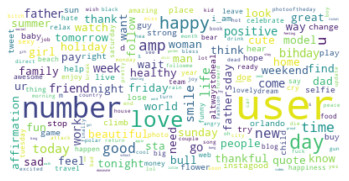

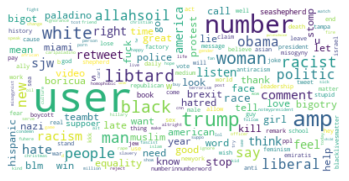

In [11]:
## visualizing hate speech and non-hate speech
from wordcloud import WordCloud
import matplotlib.pyplot as plt

result={'label':labels_list,'tweet':tweets_list}
result=pd.DataFrame(result)

for k in range(2):
    c=result[result.label==k]
    text=c['tweet'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, background_color="white", collocations=False).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()